In [184]:
#import all packages needed, define file import

import math

import networkx as nx

import geopandas as gpd

import json
from networkx.readwrite import json_graph

import gurobipy as gp
from gurobipy import GRB

from gerrychain import Graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [185]:
#read in the .shp and json file information for MT
shp_filename = 'MT_county.shp'
df = gpd.read_file( shp_filename ) 
json_filename = 'MT_county.json'
G_Montana = read_graph_from_json( json_filename )

##show nodes and verticies for visual confirmation
#print("The graph G_Montana contains:")
#print()
#print("The nodes:")
#print(G_Montana.nodes)
#print()
#print("And edges:")
#print(G_Montana.edges)

##prints, for each node of the graph, its node #, county name, and population
#
for node in G_Montana.nodes:
    county_name = G_Montana.nodes[node]['NAME20']
    county_population = G_Montana.nodes[node]['P0010001']
    G_Montana.nodes[node]['TOTPOP'] = county_population   #rolls over the identifier P0010001 with TOTPOP for all nodes
#    print("Node",node,"represents",county_name,"County, pop:",county_population)

In [186]:
# create model 
m = gp.Model()

In [187]:
m.reset() #optional model reset to test adjustments

Discarded solution information


In [188]:
# start of optimization model

#checklist:
## [x] set deviation to appropriate level - video assigned 1% deviation. However, I have pushed this further down towards the limit experimentally to find something that is closer to ideal without upsetting the compactness we achieve. 
## [x] build in compactness
## [] set other parameters?
## [x] set proper anchor locations? - this became redundant

# define variables to be used within the model
k = 2 #----------------------------------------------------------# desired number of districts
x = m.addVars( G_Montana.nodes, k, vtype=GRB.BINARY ) #----------# x[i,j] = 1 when county i is assigned to district j
y = m.addVars( G_Montana.edges, vtype=GRB.BINARY ) #-------------# y[u,v] = 1 when edge {u,v} is cut
#r = m.addVars( G_Montana.nodes, k, vtype=GRB.BINARY ) #----------# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
deviation = 0.00010 #---------------------------------------------# lecture video says to set at 1%. 2020 %range deviation of population between districts is 6.98%: https://www.ncsl.org/elections-and-campaigns/2020-redistricting-deviation-table
total_population = sum( G_Montana.nodes[i]['TOTPOP'] for i in G_Montana.nodes ) # extracts the sum of all county populations from the original file
ideal_population = total_population / k #------------------------# gives the unadjusted population per district
L = math.ceil( ( 1 - (deviation / 2 )) * ideal_population ) #----# next highest integer of 1 minus the deviation percentage from the ideal population number
U = math.floor( ( 1 + (deviation / 2 )) * ideal_population ) #---# next lowest integer of the 1 plus the deviation percentage from the ideal population number
#L = math.floor( ideal_population ) #-----------------------------# next lowest integer of the ideal population number
#U = math.ceil( ideal_population ) #------------------------------# next highest integer of the ideal population number
percent_of_total = round((((U-L)*k)/total_population)*100,2) #---# backs out the percent of the total population as a checksum for our inputs
#r[46,0].LB = 1 #-------------------------------------------------# fix Lewis and Clark county as root of district 0 - in early testing, this closed a large gap in the district and made it much more consolidated, further optimization meant this constraint became redundant.
#r[48,1].LB = 1 #-------------------------------------------------# fix Garfield county as root of district 1 - this was an arbitrary choice
# Add flow variables: f[u,v] = amount of flow sent across arc uv, Flows are sent across arcs of the directed version of G which we call DG 
#DG = nx.DiGraph(G_Montana) #-------------------------------------# directed version of G
#f = m.addVars( DG.edges ) #--------------------------------------# assigns all weights on edges based on DG??
#M = G_Montana.number_of_nodes() - k + 1 #------------------------# The big-M proposed by Hojny et al.

#do a double take
if(percent_of_total == (deviation*100)):
    checksum="  Great!! This matches our input!!"
else:checksum="  This math is not mathing. :("

# Garbage in??
print("The total population of Montana in the 2020 census was taken to be",total_population,"people.")
print("For",k,"districts with a deviation set to",deviation*100,"% this gives:")
print(" - The Lower district population bound to be:",L)
print(" - The Upper district population bound to be:",U)
print(" - The absolute district population range to be:",(U-L),"- This is ~",percent_of_total,"% of",total_population,checksum)
#print(math.ceil(1.2))  #demo the .ceil operator - returns the next highest integer
#print(math.floor(1.8)) #demo the .floor operator - returns the next lowest integer

The total population of Montana in the 2020 census was taken to be 1084225 people.
For 2 districts with a deviation set to 0.01 % this gives:
 - The Lower district population bound to be: 542086
 - The Upper district population bound to be: 542139
 - The absolute district population range to be: 53 - This is ~ 0.01 % of 1084225   Great!! This matches our input!!


In [189]:
# objective is to minimize cut edges while considering the total permiter length
#m.setObjective( gp.quicksum( y[u,v] for u,v in G_Montana.edges ), GRB.MINIMIZE ) # without minimum perimeter
m.setObjective( gp.quicksum( G_Montana.edges[u,v]['shared_perim'] * y[u,v] for u,v in G_Montana.edges ), GRB.MINIMIZE ) # with minimum perimter, we can come to the same conclusion with or without. 

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G_Montana.nodes )

# add constraints saying that each district has a population at least L and at most U.
m.addConstrs( gp.quicksum( G_Montana.nodes[i]['TOTPOP'] * x[i,j] for i in G_Montana.nodes ) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G_Montana.nodes[i]['TOTPOP'] * x[i,j] for i in G_Montana.nodes ) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G_Montana.edges for j in range(k) )

# Each district j should have one root
#m.addConstrs( gp.quicksum( r[i,j] for i in G_Montana.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
#m.addConstrs( r[i,j] <= x[i,j] for i in G_Montana.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
#m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G_Montana.neighbors(i) ) 
#             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G_Montana.nodes )

# do not send flow across cut edges
#m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G_Montana.edges )

m.update()

In [190]:
# solve IP model

m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 20.6.0 20G165)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 336 rows, 250 columns and 1164 nonzeros
Model fingerprint: 0x57e51d97
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [2e-03, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Found heuristic solution: objective 61.6087254
Presolve removed 58 rows and 56 columns
Presolve time: 0.00s
Presolved: 278 rows, 194 columns, 940 nonzeros
Variable types: 0 continuous, 194 integer (194 binary)

Root relaxation: objective 0.000000e+00, 86 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   56   61.60873    0.00000   10

The number of cut edges is 10.09409

Is district 0 connected? True
Is district 1 connected? True

District 0 has a population of 542131
District 1 has a population of 542094

This is a range of ~ 0.007 %
or an absolute difference of 37 people

District 0 has population 542131 and contains counties ['Broadwater', 'Big Horn', 'Custer', 'Richland', 'Wibaux', 'Golden Valley', 'Carbon', 'Blaine', 'Judith Basin', 'Park', 'Roosevelt', 'Fallon', 'McCone', 'Stillwater', 'Dawson', 'Powder River', 'Hill', 'Treasure', 'Yellowstone', 'Jefferson', 'Wheatland', 'Valley', 'Petroleum', 'Phillips', 'Sheridan', 'Daniels', 'Prairie', 'Madison', 'Beaverhead', 'Musselshell', 'Chouteau', 'Meagher', 'Rosebud', 'Sweet Grass', 'Garfield', 'Carter', 'Gallatin', 'Silver Bow', 'Fergus']

District 1 has population 542094 and contains counties ['Sanders', 'Lincoln', 'Granite', 'Toole', 'Powell', 'Teton', 'Glacier', 'Lake', 'Mineral', 'Deer Lodge', 'Ravalli', 'Missoula', 'Lewis and Clark', 'Pondera', 'Liberty', 'Casc

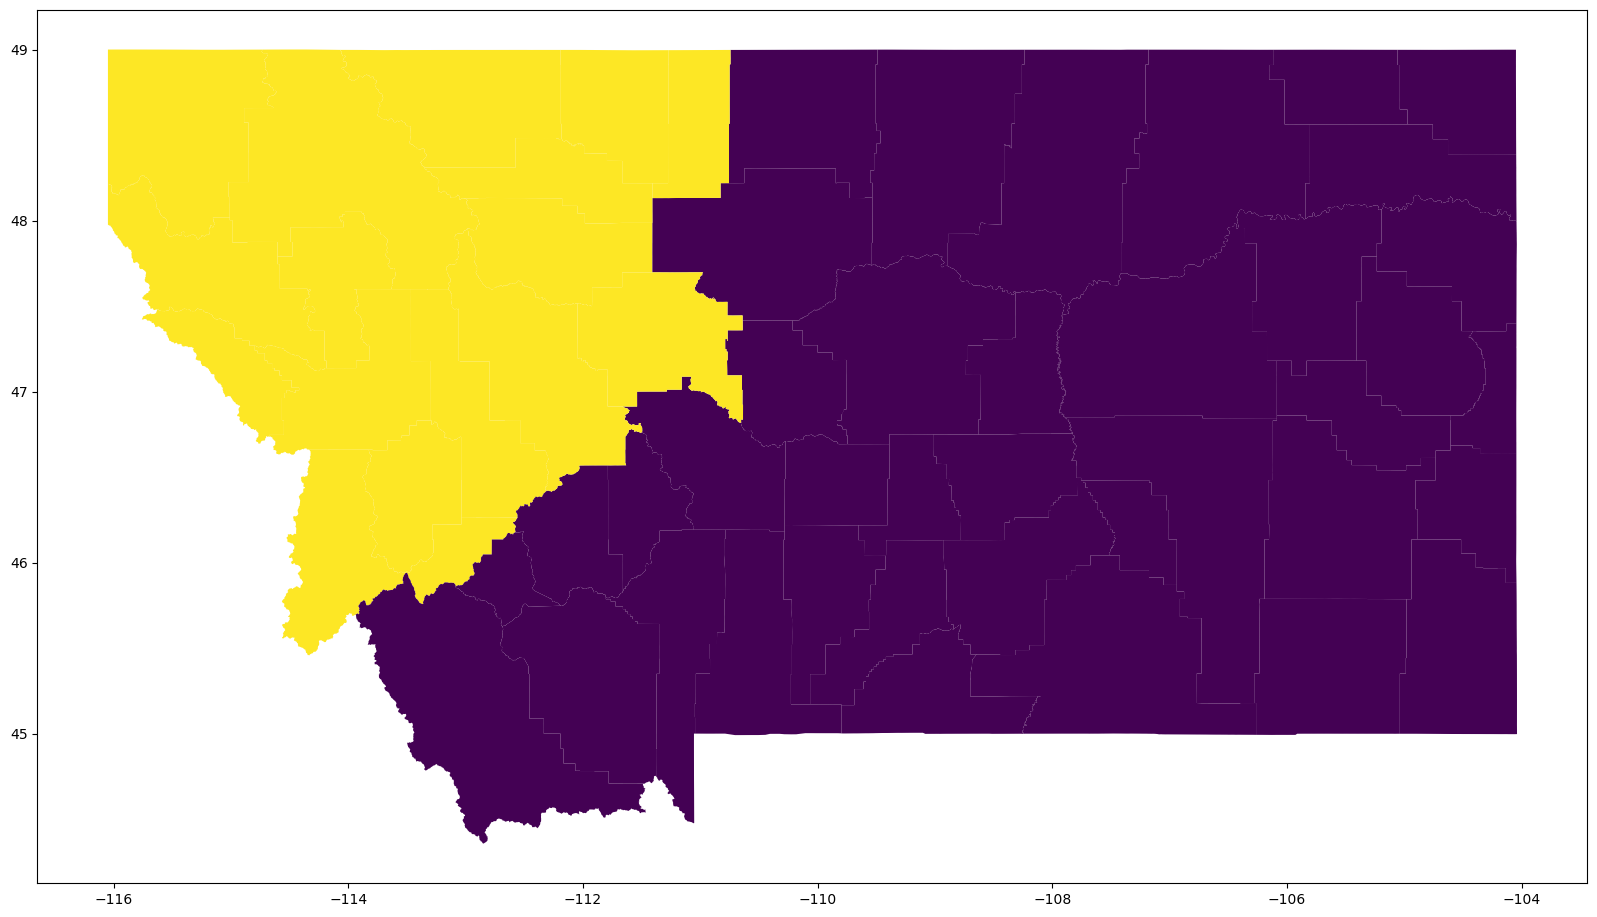

In [192]:
#compile results and generate district map

print("The number of cut edges is",round(m.objval,5))
print()

# retrieve the districts and their populations
districts = [ [i for i in G_Montana.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G_Montana.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G_Montana.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]
absolute_difference = abs(district_populations[0]-district_populations[1])
percent_difference = round(((absolute_difference*2)/total_population)*100,3)

#validate that the districts we created are in fact connected. 
for district in range(k):
    print("Is district", district , "connected?", nx.is_connected( G_Montana.subgraph( district ) ) )
#print(districts[0])
#print(districts[1])
print()

for i in range(k):
    print("District",i,"has a population of",district_populations[i])
print()
print("This is a range of ~",percent_difference,"%")
print("or an absolute difference of", absolute_difference,"people")
print()

# print district info in readable format
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

assignment = [ -1 for i in G_Montana.nodes ]
labeling = { i : j for i in G_Montana.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G_Montana.nodes[i]['GEOID20'] : i for i in G_Montana.nodes }

# pick a position u in the dataframe
for u in range(G_Montana.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment',figsize=(20,30)).get_figure()